In [15]:
import json
import os
import torch
from sn2_cuda import SN2Solver
from scipy import stats
from scipy.stats import beta
from scipy.integrate import quad
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# @title Select numerical precision
numerical_precision = torch.float64 # @param ["torch.float32","torch.float64"] {"type":"raw"}
num_experiments = 500 # @param {"type":"slider","min":1,"max":1000,"step":1}

In [3]:
results_file_name = f"numerical_stability_results_{str(numerical_precision).rsplit('.')[-1]}_n{num_experiments}.json"

if os.path.exists(results_file_name):
    with open(results_file_name, 'r') as fp:
        results = json.load(fp)
else:
    from numerical_stability import get_results

    with open("pmDAGs.json", 'r') as fp:
        data = json.load(fp)

    results = get_results(data, num_experiments, numerical_precision)

    with open(results_file_name, 'w') as fp:
        json.dump(results, fp)

In [4]:
def prob_a_better(p_a, p_b, n):
    def prob_p1_gt_p2(alpha1, beta1, alpha2, beta2):
        integrand = lambda p: beta.pdf(p, alpha1, beta1) * beta.cdf(p, alpha2, beta2)
        result, _ = quad(integrand, 0, 1)
        return result

    # Observed data
    n_a, n_b = p_a * n, p_b * n

    # Prior: Beta(1, 1) = Uniform (uninformative)
    alpha, beta_param = 1, 1

    return prob_p1_gt_p2(n_a + alpha, n - n_a + beta_param, n_b + alpha, n - n_b + beta_param)

In [5]:
df = pd.DataFrame(columns=['name', 'method', 'lr', 'success_rate'])

for name, experiments in results.items():
    for method, tests in experiments.items():
        for i, (lr, success_rate) in enumerate(tests.items()):
            df.loc[len(df), df.columns] = name, method, lr, success_rate

methods = df["method"].unique()
df = df.pivot(index=("name", "lr"), columns="method", values="success_rate").reset_index()
df[methods] = df[methods].astype(float)
df["diff"] = df.apply(lambda row: -np.diff(row[methods])[0], axis=1)
df[f"prob_{methods[0]}_better"] = df.apply(lambda row: prob_a_better(*row[methods], num_experiments), axis=1)
df.round(3)

method,name,lr,METHODS.ACCUM,METHODS.COVAR,diff,prob_METHODS.ACCUM_better
0,IV,0.0001,0.996,0.998,-0.002,0.312
1,IV,0.001,0.970,0.980,-0.010,0.160
2,IV,0.01,0.914,0.902,0.012,0.743
3,IV,0.1,0.544,0.510,0.034,0.859
4,IV,1,0.026,0.024,0.002,0.579
5,M,0.0001,1.000,1.000,-0.000,0.500
6,M,0.001,1.000,0.998,0.002,0.750
7,M,0.01,0.982,0.992,-0.010,0.088
8,M,0.1,0.886,0.856,0.030,0.921
9,M,1,0.148,0.144,0.004,0.571


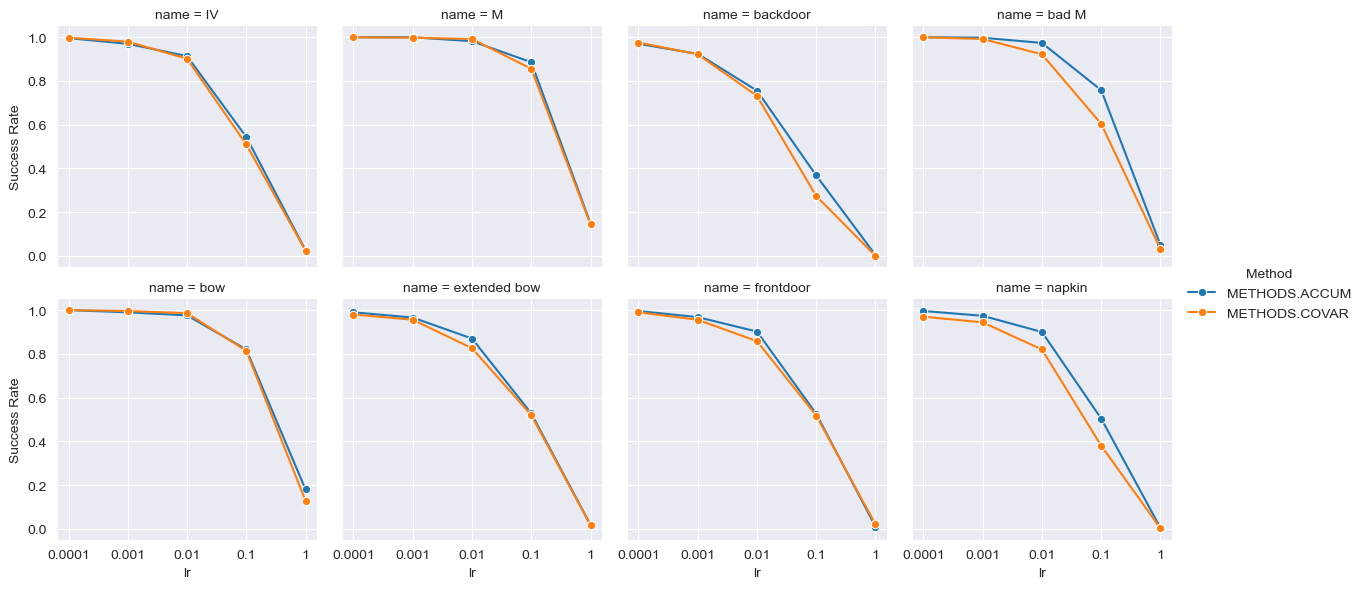

In [6]:
grid = sns.FacetGrid(df, col="name", palette="tab20c", col_wrap=4, height=3)
palette = sns.color_palette("tab10")

for i, method in enumerate(methods):
    grid.map(sns.lineplot, "lr", method, label=method, color=palette[i], marker='o')

grid.set_ylabels("Success Rate")
grid.add_legend(title="Method")

In [24]:
stats_df = pd.DataFrame()
n = len(df['name'].unique())
alpha = 0.05

stats_df['average'] = df.groupby(['lr'])[f"prob_{methods[0]}_better"].mean()
std = df.groupby(['lr'])[f"prob_{methods[0]}_better"].std(ddof=1)
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
stats_df['margin_error'] = t_critical * (std / np.sqrt(n))

stats_df['t_statistic'] = (stats_df['average'] - 0.5) / (std / np.sqrt(n))
stats_df['confidence level'] = stats.t.cdf(stats_df['t_statistic'], df=n-1)

stats_df.round(3)

,average,margin_error,t_statistic,confidence level
lr,,,,
0.0001,0.606,0.229,1.093,0.845
0.001,0.639,0.273,1.203,0.866
0.01,0.716,0.323,1.577,0.921
0.1,0.822,0.160,4.767,0.999
1,0.665,0.235,1.661,0.930
